# Zillow Challenge: Final Model
### Heath Mills

## Table of Contents

1. [Load Data](#Load-Data)
2. [Data Cleaning & Preparation](#Data Cleaning-&-Preparation-from-Exploratory-Data-Analysis)
3. [Reduce Dimensionality](#Reduce-Dimensionality)
4. [Pickle Data](#Pickle-Data)

## Load Data

In [1]:
#Import Libraries/Packages For Use
import numpy as np 
import pandas as pd
import datetime as dt 
import os
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import ggplot as ggplot
from ggplot import * 
color = sns.color_palette()

plt.style.use('fivethirtyeight')
%matplotlib inline

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/anaconda/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:

Before I submit my model to Kaggle for score, I need to include the data cleaning steps from my Exploratory Data Analysis here as well. For now, I am just loading my data from the pickled files.

In [2]:
def load_data():
    # Pickled versions of Data Sets
    train2016_p = './pickled/train2016_p'
    train2017_p = './pickled/train2017_p'
    prop2016_p = './pickled/prop2016_p'
    prop2017_p = './pickled/prop2017_p'
    sample_p = './pickled/sample_p'

    # If pickled train2016 exists, load it; else load train_2016_v2.csv to df and pickle it
    if os.path.exists(train2016_p):
        train2016 = pd.read_pickle(train2016_p)
    else:
        # load data to df
        train2016 = pd.read_csv('./input/train_2016_v2.csv',
                            parse_dates=['transactiondate'])
        # create pickled file for storage
        train2016.to_pickle(train2016_p)

    # If pickled train2017 exists, load it; else load train_2017.csv to df and pickle it
    if os.path.exists(train2017_p):
        train2017 = pd.read_pickle(train2017_p)
    else:
        # load data to df
        train2017 = pd.read_csv('./input/train_2017.csv',
                            parse_dates=['transactiondate'])
        # create pickled file for storage
        train2017.to_pickle(train2017_p)

    # If pickled prop2016_p load it; else load properties_2016.csv to df and pickle it
    if os.path.exists(prop2016_p):
        prop2016 = pd.read_pickle(prop2016_p)
    else:
        prop2016 = pd.read_csv('./input/properties_2016.csv')
        prop2016.to_pickle(prop2016_p)

    # If pickled prop2017_p load it; else load properties_2017.csv to df and pickle it
    if os.path.exists(prop2017_p):
        prop2017 = pd.read_pickle(prop2017_p)
    else:
        prop2017 = pd.read_csv('./input/properties_2017.csv')
        prop2017.to_pickle(prop2017_p)

    # If pickled sample exists, load it; else load sample_submission.csv to df and pickle it
    if os.path.exists(sample_p):
        sample = pd.read_pickle(sample_p)
    else:
        sample = pd.read_csv('./input/sample_submission.csv')
        sample.to_pickle(sample_p)
    return prop2016, prop2017, train2016, train2017, sample

In [3]:
#Load Datasets
prop2016, prop2017, train2016, train2017, sample = load_data()

In [4]:
# Renaming the headers

# Read the feature_names file to a dataframe
col_mapping = pd.read_csv('./input/feature_names.txt', sep ="=", header=None).applymap(str.strip)
# Convert df to dict and rename using dict
mapping_dict = dict(zip(col_mapping[1], col_mapping[0]))
prop2016.rename(columns = mapping_dict, inplace=True)
prop2017.rename(columns = mapping_dict, inplace=True)

# Since we only need to rename one column in train2016 and train2017, this can be done easily
train2016.rename(columns={'parcelid':'ParcelId'}, inplace=True)
train2017.rename(columns={'parcelid':'ParcelId'}, inplace=True)

## Data Cleaning & Preparation from Exploratory Data Analysis

The data cleaning done in the steps below is explained in more detail in the Exploratory Data Analysis notebook. It is run here as well for Kaggle competition submission purposes.

In [5]:
# Replace True with 1 in flag_hot_tub_spa & flag_fireplace
prop2016['flag_hot_tub_spa'] = prop2016['flag_hot_tub_spa'].replace(True,1)
prop2017['flag_hot_tub_spa'] = prop2017['flag_hot_tub_spa'].replace(True,1)
prop2016['flag_fireplace'] = prop2016['flag_fireplace'].replace(True,1)
prop2017['flag_fireplace'] = prop2017['flag_fireplace'].replace(True,1)

In [6]:
# Replace 'Y' with 1 in flag_hot_tub_spa & flag_fireplace
prop2016['flag_tax_owed_2015'] = prop2016['flag_tax_owed_2015'].replace('Y',1)
prop2017['flag_tax_owed_2015'] = prop2017['flag_tax_owed_2015'].replace('Y',1)

In [7]:
### Combine flag_fireplace & count_fireplace
# Fill any NAN values of count_fireplace with flag_fireplace in prop2016 and prop2017
prop2016.count_fireplace.combine_first(prop2016.flag_fireplace)
prop2017.count_fireplace.combine_first(prop2017.flag_fireplace)

# Drop flag_fireplace
prop2016 = prop2016.drop('flag_fireplace', axis=1)
prop2017 = prop2017.drop('flag_fireplace', axis=1)

# Fill NaN values for count_fireplace with 0 (i.e. no fireplaces)
prop2016['count_fireplace']=prop2016['count_fireplace'].fillna(0)
prop2017['count_fireplace']=prop2017['count_fireplace'].fillna(0)

In [8]:
### Combine sqft_first_floor & sqft_first_floor_finished
# Fill any NAN values of sqft_first_floor with sqft_first_floor_finished in prop2016 and prop2017
prop2016.sqft_first_floor.combine_first(prop2016.sqft_first_floor_finished)
prop2017.sqft_first_floor.combine_first(prop2017.sqft_first_floor_finished)

# Drop sqft_first_floor_finished
prop2016 = prop2016.drop('sqft_first_floor_finished', axis=1)
prop2017 = prop2017.drop('sqft_first_floor_finished', axis=1)

In [9]:
### Combine flag_hot_tub_spa, flag_hot_tub_spa2, flag_pool+hot_tub_spa, flag_pool, count_pools
# Fill any NAN values of flag_pool with count_pools in prop2016 and prop2017
prop2016.flag_pool.combine_first(prop2016.count_pools)
prop2017.flag_pool.combine_first(prop2017.count_pools)

# Drop count_pools
prop2016 = prop2016.drop('count_pools', axis=1)
prop2017 = prop2017.drop('count_pools', axis=1)

# Fill any NAN values of flag_hot_tub_spa with flag_hot_tub_spa2 in prop2016 and prop2017
prop2016.flag_hot_tub_spa.combine_first(prop2016.flag_hot_tub_spa2)
prop2017.flag_hot_tub_spa.combine_first(prop2017.flag_hot_tub_spa2)

# Drop count_pools
prop2016 = prop2016.drop('flag_hot_tub_spa2', axis=1)
prop2017 = prop2017.drop('flag_hot_tub_spa2', axis=1)

# Fill any NAN values of flag_hot_tub_spa with flag_pool+hot_tub_spa in prop2016 and prop2017
prop2016.flag_hot_tub_spa.combine_first(prop2016.flag_pool_hot_tub_spa)
prop2017.flag_hot_tub_spa.combine_first(prop2017.flag_pool_hot_tub_spa)

# Fill any NAN values of flag_pool with count_pools in prop2016 and prop2017
prop2016.flag_pool.combine_first(prop2016.flag_pool_hot_tub_spa)
prop2017.flag_pool.combine_first(prop2017.flag_pool_hot_tub_spa)

# Drop count_pools
prop2016 = prop2016.drop('flag_pool_hot_tub_spa', axis=1)
prop2017 = prop2017.drop('flag_pool_hot_tub_spa', axis=1)

# Fill NaN values for flag_pool with 0 (i.e. no fireplaces)
prop2016['flag_pool']=prop2016['flag_pool'].fillna(0)
prop2017['flag_pool']=prop2017['flag_pool'].fillna(0)

# Fill NaN values for flag_hot_tub_spa with 0 (i.e. no fireplaces)
prop2016['flag_hot_tub_spa']=prop2016['flag_hot_tub_spa'].fillna(0)
prop2017['flag_hot_tub_spa']=prop2017['flag_hot_tub_spa'].fillna(0)

In [10]:
### Combine date_tax_owed & flag_tax_owed_2015
# Replace 1 with 2015 in flag_tax_owed_2015
prop2016['flag_hot_tub_spa'] = prop2016['flag_hot_tub_spa'].replace(1,2015)
prop2017['flag_hot_tub_spa'] = prop2017['flag_hot_tub_spa'].replace(1,2015)

# Fill any NAN values of date_tax_owed with flag_tax_owed_2015 in prop2016 and prop2017
prop2016.date_tax_owed.combine_first(prop2016.flag_tax_owed_2015)
prop2017.date_tax_owed.combine_first(prop2017.flag_tax_owed_2015)

# Drop flag_tax_owed_2015
prop2016 = prop2016.drop('flag_tax_owed_2015', axis=1)
prop2017 = prop2017.drop('flag_tax_owed_2015', axis=1)

In [11]:
### Combine id_censustract_and_blockid_raw, id_censustract_and_blockid, loc_county_id, loc_county_fips
# Replace values in loc_county_fips with 1, 2 or 3
fips_map = {6037: 0, 6059: 1, 6111: 2}
prop2016['loc_county_fips'] = prop2016['loc_county_fips'].map(fips_map)
prop2017['loc_county_fips'] = prop2017['loc_county_fips'].map(fips_map)

# Replace values in loc_county_id with 1, 2 or 3
county_map = {3101: 0, 1286: 1, 2061: 2}
prop2016['loc_county_id'] = prop2016['loc_county_id'].map(county_map)
prop2017['loc_county_id'] = prop2017['loc_county_id'].map(county_map)

# Fill any NAN values of loc_county_id with loc_county_fips in prop2016 and prop2017
prop2016.loc_county_id.combine_first(prop2016.loc_county_fips)
prop2017.loc_county_id.combine_first(prop2017.loc_county_fips)

prop2016 = prop2016.drop(['id_censustract_and_blockid','id_censustract_and_blockid_raw', 'loc_county_fips'],axis=1)
prop2017 = prop2017.drop(['id_censustract_and_blockid','id_censustract_and_blockid_raw', 'loc_county_fips'],axis=1)

In [12]:
### Combine Data
merged2016 = train2016.merge(prop2016, how='left', on='ParcelId')
merged2017 = train2017.merge(prop2017, how='left', on='ParcelId')

In [13]:
# Create a month variable from the transactiondate field
merged2016['transaction_month'] = merged2016['transactiondate'].dt.month
merged2017['transaction_month'] = merged2017['transactiondate'].dt.month

In [14]:
# Using the information from the data dictionary, I know that there is already a value for none in type_air_cond
merged2016['type_air_cond'] = merged2016['type_air_cond'].fillna(5)
merged2017['type_air_cond'] = merged2017['type_air_cond'].fillna(5)

# Using the data dictionary, I've decided to create another value for type_arch_style: 19 = Other
merged2016['type_arch_style'] = merged2016['type_arch_style'].fillna(19)
merged2017['type_arch_style'] = merged2017['type_arch_style'].fillna(19)

# Basement square footage can be filled with 0
merged2016['sqft_basement'] = merged2016['sqft_basement'].fillna(0)
merged2017['sqft_basement'] = merged2017['sqft_basement'].fillna(0)
merged2016['count_garage'] = merged2016['count_garage'].fillna(0)
merged2017['count_garage'] = merged2017['count_garage'].fillna(0)

merged2016['sqft_garage'] = merged2016['sqft_garage'].fillna(0)
merged2017['sqft_garage'] = merged2017['sqft_garage'].fillna(0)
merged2016['loc_zipcode'] = merged2016['loc_zipcode'].fillna(0)
merged2017['loc_zipcode'] = merged2017['loc_zipcode'].fillna(0)
merged2016['loc_neighborhood_id'] = merged2016['loc_neighborhood_id'].fillna(0)
merged2017['loc_neighborhood_id'] = merged2017['loc_neighborhood_id'].fillna(0)
merged2016['loc_city_id'] = merged2016['loc_city_id'].fillna(0)
merged2017['loc_city_id'] = merged2017['loc_city_id'].fillna(0)
merged2016['loc_county_id'] = merged2016['loc_county_id'].fillna(0)
merged2017['loc_county_id'] = merged2017['loc_county_id'].fillna(0)
merged2016['type_building_material'] = merged2016['type_building_material'].fillna(0)
merged2017['type_building_material'] = merged2017['type_building_material'].fillna(0)
merged2016['date_tax_owed'] = merged2016['date_tax_owed'].fillna(0)
merged2017['date_tax_owed'] = merged2017['date_tax_owed'].fillna(0)
merged2016['sqft_total_all'] = merged2016['sqft_total_all'].fillna(0)
merged2017['sqft_total_all'] = merged2017['sqft_total_all'].fillna(0)
merged2016['sqft_total_finished'] = merged2016['sqft_total_finished'].fillna(0)
merged2017['sqft_total_finished'] = merged2017['sqft_total_finished'].fillna(0)
merged2016['loc_longitude'] = merged2016['loc_longitude'].fillna(0)
merged2017['loc_longitude'] = merged2017['loc_longitude'].fillna(0)
merged2016['loc_latitude'] = merged2016['loc_latitude'].fillna(0)
merged2017['loc_latitude'] = merged2017['loc_latitude'].fillna(0)

# Using the information from the data dictionary, I know that there is already a value for none in type_air_cond
merged2016['type_heating'] = merged2016['type_heating'].fillna(13)
merged2017['type_heating'] = merged2017['type_heating'].fillna(13)

# Assume count_stories is 1
merged2016['count_home_stories'] = merged2016['count_home_stories'].fillna(1)
merged2017['count_home_stories'] = merged2017['count_home_stories'].fillna(1)

# Bathroom counts, bedroom counts and many sqft measures are being set to the median value
merged2016['count_total_bath'] = merged2016['count_total_bath'].fillna(merged2016['count_total_bath'].median())
merged2017['count_total_bath'] = merged2017['count_total_bath'].fillna(merged2017['count_total_bath'].median())
merged2016['count_total_bed'] = merged2016['count_total_bed'].fillna(merged2016['count_total_bed'].median())
merged2017['count_total_bed'] = merged2017['count_total_bed'].fillna(merged2017['count_total_bed'].median())
merged2016['count_total_bath2'] = merged2016['count_total_bath2'].fillna(merged2016['count_total_bath2'].median())
merged2017['count_total_bath2'] = merged2017['count_total_bath2'].fillna(merged2017['count_total_bath2'].median())
merged2016['type_building_quality'] = merged2016['type_building_quality'].fillna(merged2016['type_building_quality'].median())
merged2017['type_building_quality'] = merged2017['type_building_quality'].fillna(merged2017['type_building_quality'].median())
merged2016['sqft_first_floor'] = merged2016['sqft_first_floor'].fillna(merged2016['sqft_first_floor'].median())
merged2017['sqft_first_floor'] = merged2017['sqft_first_floor'].fillna(merged2017['sqft_first_floor'].median())
merged2016['sqft_total_area'] = merged2016['sqft_total_area'].fillna(merged2016['sqft_total_area'].median())
merged2017['sqft_total_area'] = merged2017['sqft_total_area'].fillna(merged2017['sqft_total_area'].median())
merged2016['count_full_bath'] = merged2016['count_full_bath'].fillna(merged2016['count_full_bath'].median())
merged2017['count_full_bath'] = merged2017['count_full_bath'].fillna(merged2017['count_full_bath'].median())

# Keep NaN in sqft_living_perimeter and sqft_total_lot for now
# Very little information or values for count_3/4_bath so drop for now
#merged2016 = merged2016.drop(['count_34_bath', 'count_total_room'], axis=1)
#merged2017 = merged2017.drop(['count_34_bath', 'count_total_room'], axis=1)

# Creating a category for the following variables: 0 = Other
merged2016['type_building_frame'] = merged2016['type_building_frame'].fillna(0)
merged2017['type_building_frame'] = merged2017['type_building_frame'].fillna(0)
merged2016['type_deck'] = merged2016['type_deck'].fillna(0)
merged2017['type_deck'] = merged2017['type_deck'].fillna(0)

In [18]:
# split data into X and y while filling nulls with 0 and dropping a few categorical variables that we may want to add in later
x6 = merged2016.drop(['ParcelId', 'logerror', 'transactiondate', 'transaction_month', 'text_zoning', 'type_county_zoning'], axis=1).fillna(0)
y6 = merged2016['logerror']
x7 = merged2017.drop(['ParcelId', 'logerror', 'transactiondate', 'transaction_month', 'text_zoning', 'type_county_zoning'], axis=1).fillna(0)
y7 = merged2017['logerror']

# convert X to float
X6 = x6.apply(pd.to_numeric)
X7 = x7.apply(pd.to_numeric)

Note: I had to make a last minute change to eliminate normalization due to difficulties denormalizing the data for submission.

In [19]:
# Normalize features
#scaler = StandardScaler()
X6 = X6.fillna(0)
#X6_s = scaler.fit_transform(X6)
X6_s = X6
#y6_s = scaler.fit_transform(y6.values.reshape(-1, 1))
y6_s = y6

X7 = X7.fillna(0)
#X7_s = scaler.fit_transform(X7)
X7_s = X7
#y7_s = scaler.fit_transform(y7.values.reshape(-1, 1))
y7_s = y7

# Split into test / training
X6_train, X6_test, y6_train, y6_test = train_test_split(X6_s, y6_s, test_size=0.2, random_state=7)
X7_train, X7_test, y7_train, y7_test = train_test_split(X7_s, y7_s, test_size=0.2, random_state=7)

## Reduce Dimensionality

### Principle Component Analysis
The features with the highest weights in the table should be considered the most important.

In [20]:
### 2016 Data
# Extract features
pca6 = PCA(n_components=5)
fit6 = pca6.fit(X6_s)
# Summarize components
print("Explained Variance: ", fit6.explained_variance_ratio_)

('Explained Variance: ', array([ 0.65103361,  0.22016769,  0.04862737,  0.03422263,  0.02559833]))


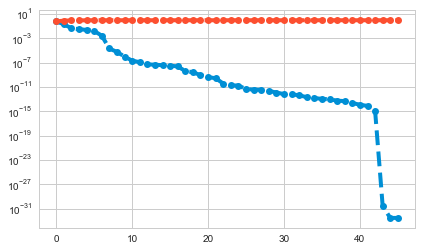

In [21]:
### 2016 Data
# Visualize results
pca_viz = PCA().fit(X6_s);

with plt.style.context('seaborn-whitegrid'):
    plt.semilogy(pca_viz.explained_variance_ratio_, '--o');
    plt.semilogy(pca_viz.explained_variance_ratio_.cumsum(), '--o');
    plt.show()

In [22]:
### 2016 Data
# Recover weights of variables
ident6 = np.identity(X6_train.shape[1])
coef6 = pd.DataFrame(pca6.transform(ident6), columns = ['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5'], index = X6.columns)

# Print results (first five rows)
coef6.sort_values(by = 'PC-1', ascending = True, kind = 'mergesort').head()

,PC-1,PC-2,PC-3,PC-4,PC-5
loc_latitude,438588.773228,-1.186672e+08,3.135419e+07,3.622526e+06,6.838767e+06
loc_longitude,438588.818824,-1.186672e+08,3.135419e+07,3.622526e+06,6.838767e+06
sqft_total_lot,438588.821642,-1.186672e+08,3.135419e+07,3.622525e+06,6.838767e+06
loc_city_id,438588.823966,-1.186672e+08,3.135419e+07,3.622525e+06,6.838767e+06
sqft_living_perimeter,438588.825360,-1.186672e+08,3.135419e+07,3.622525e+06,6.838767e+06


In [23]:
### 2017 Data
# Extract features
pca7 = PCA(n_components=5)
fit7 = pca7.fit(X7_s)
# Summarize components
print("Explained Variance: ", fit7.explained_variance_ratio_)

('Explained Variance: ', array([ 0.89407848,  0.09054978,  0.0060918 ,  0.00469747,  0.00250968]))


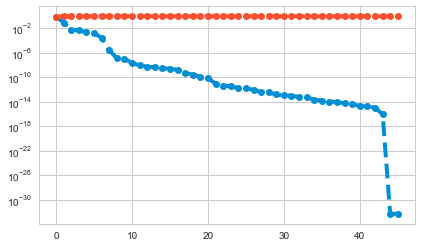

In [24]:
### 2017 Data
# Visualize results
pca_viz = PCA().fit(X7_s);

with plt.style.context('seaborn-whitegrid'):
    plt.semilogy(pca_viz.explained_variance_ratio_, '--o');
    plt.semilogy(pca_viz.explained_variance_ratio_.cumsum(), '--o');
    plt.show()

In [25]:
### 2017 Data
# Recover weights of variables
ident7 = np.identity(X7_train.shape[1])
coef7 = pd.DataFrame(pca7.transform(ident7), columns = ['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5'], index = X7.columns)

# Print results (first five rows)
coef7.sort_values(by = 'PC-1', ascending = True, kind = 'mergesort').head()

,PC-1,PC-2,PC-3,PC-4,PC-5
loc_latitude,1.229450e+08,61833.854128,568417.461877,142880.857111,94834.487483
value_tax_total,1.229450e+08,61834.679706,568416.710127,142880.282415,94834.390536
value_tax_lot,1.229450e+08,61834.471845,568416.379546,142880.999237,94834.390008
value_tax_building,1.229450e+08,61834.100431,568416.924813,142879.748732,94834.393042
loc_neighborhood_id,1.229450e+08,61833.899479,568416.499763,142880.425883,94835.386082


### Tree-Based Feature Importance
Getting a quick tree-based feature importance classification is the final step that I am taking before I build a cross-validated model. I'm using a variation of a LightGBM model shared by another member of the Kaggle community. 

LightGBM is a gradient boosting framework based on decision tree algorithms that can be used for quick ranking and classification tasks. It was recently open-sourced by Microsoft as part of the DMTK project.

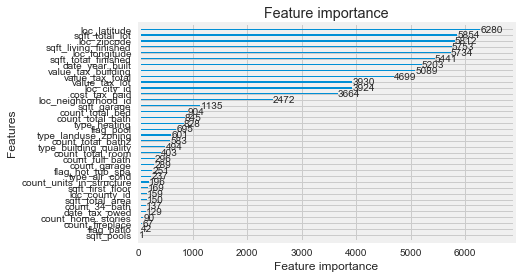

In [26]:
### 2016 Data
# Convert dataset
d_train6 = lgb.Dataset(X6, label=y6.ravel())

# Set parameters
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.85 #
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 400         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 5
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

# Train model
# Train model
clf6 = lgb.train(params, 
               d_train6,
               500)

# Plot importance
lgb.plot_importance(clf6)
plt.show()

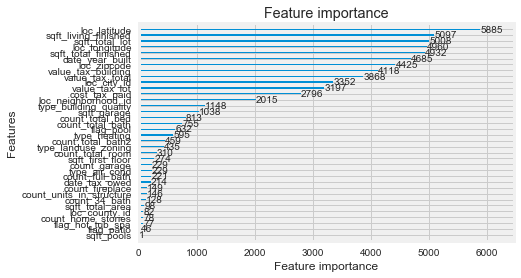

In [27]:
### 2017 Data
# Convert dataset
d_train7 = lgb.Dataset(X7, label=y7.ravel())

# Set parameters
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.85 #
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 400         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 5
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

# Train model
# Train model
clf7 = lgb.train(params, 
               d_train7,
               500)

# Plot importance
lgb.plot_importance(clf7)
plt.show()

## Cross-Validated Model

### K-Fold Cross-Validation of XGBoost
XGBoost appears to be the model of choice for this project from my research.

In [28]:
### 2016 Data
# Define datasets
d6_train = xgb.DMatrix(X6_train, label=y6_train)
d6_test = xgb.DMatrix(X6_test, label=y6_test)

# Define learning parameters
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

# Run algo
watchlist6 = [(d6_train, 'train'), (d6_test, 'valid')]
clf_xgb6 = xgb.train(params, 
                    d6_train, 
                    10000, 
                    watchlist6, # computes both in-sample and out-of-sample errors
                    early_stopping_rounds=100, # quit training after accuracy metric hasn't improved in x rounds
                    verbose_eval=500)

# Make predictions
xgboost_pred6 = clf_xgb6.predict(d6_test)

[0]	train-mae:0.487174	valid-mae:0.487738
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[347]	train-mae:0.06735	valid-mae:0.068695



In [29]:
### 2017 Data
# Define datasets
d7_train = xgb.DMatrix(X7_train, label=y7_train)
d7_test = xgb.DMatrix(X7_test, label=y7_test)

# Define learning parameters
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

# Run algo
watchlist7 = [(d7_train, 'train'), (d7_test, 'valid')]
clf_xgb7 = xgb.train(params, 
                    d7_train, 
                    10000, 
                    watchlist7, # computes both in-sample and out-of-sample errors
                    early_stopping_rounds=100, # quit training after accuracy metric hasn't improved in x rounds
                    verbose_eval=500)

# Make predictions
xgboost_pred7 = clf_xgb7.predict(d7_test)

[0]	train-mae:0.485226	valid-mae:0.486297
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[376]	train-mae:0.069462	valid-mae:0.071133



In [30]:
print xgboost_pred7

[ 0.02311331  0.01596597  0.00856775 ...,  0.00737023  0.01677984
  0.00635612]


In [ ]:
Note: I ran into a late problem with creation of my submission file. I couldn't get this solved before class today but I hope to fix the issue and get a submission into the competition before the deadl 

In [36]:
# Prepare the submission data
merge2017 = pd.merge(sample, prop2017, on='ParcelId', how='left')
merge2017 = merge2017.fillna(0)

merge2016 = pd.merge(sample, prop2016, on='ParcelId', how='left')
merge2016 = merge2016.fillna(0)

Final2016_predictions = clf_xgb6.predict(merge2016)
Final2017_predictions = clf_xgb7.predict(merge2017)

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [ ]:
submission_file = pd.read_csv('sample_submission.csv') 
for column in submission_file.columns[submission_file.columns == 201610]:
    submission_file[column] = Final2016_predictions
for column in submission_file.columns[submission_file.columns == 201611]:
    submission_file[column] = Final2016_predictions
for column in submission_file.columns[submission_file.columns == 201612]:
    submission_file[column] = Final2016_predictions
for column in submission_file.columns[submission_file.columns == 201710]:
    submission_file[column] = Final2017_predictions
for column in submission_file.columns[submission_file.columns == 201711]:
    submission_file[column] = Final2017_predictions
for column in submission_file.columns[submission_file.columns == 201712]:
    submission_file[column] = Final2017_predictions

In [ ]:
submission_file.to_csv('RF_final_predictions.csv', index=False, float_format='%.4f')